# Earthquakes

In this notebook we'll try and model the intensity of earthquakes, basically replicating one of the examples in [this](http://user.it.uu.se/~thosc112/dahlin2014-lic.pdf) paper. To that end, let's first grab the data we need from USGS. We then filter the data to only include earthquakes of a magnitude 7.0, on the Richter scale, or higher.

<AxesSubplot:xlabel='time'>

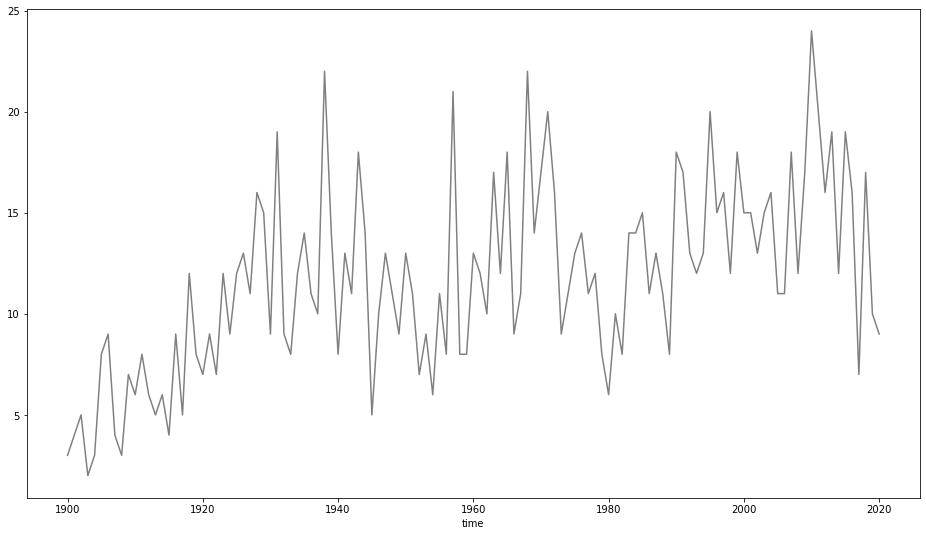

In [11]:
from requests import get
from datetime import datetime
from json import loads
import pandas as pd

url = url = "https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?minsig=600"

resp = get(url, params={"starttime": datetime(1900, 1, 1), "endtime": datetime(2021, 1, 1)})
json = resp.json()

data = pd.DataFrame.from_dict((i["properties"] for i in json["features"]), orient="columns")
data.set_index("time", inplace=True)

data.index = pd.to_datetime(data.index, unit="ms")
data = data.where(data["mag"] >= 7.0).sort_index()

by_year = data.groupby(data.index.year)["mag"].count()
by_year.plot(figsize=(16, 9), color="gray")

Next, we'll setup the model for the data. We'll use the same one as Dahlin uses, i.e.
\begin{cases}
d \log {\lambda_t} = \kappa (\mu - \log{\lambda_t})dt + \sigma dW_t, \\
Y_t \sim \mathcal{P} \left ( \beta \lambda_t \right),
\end{cases}
where $\mathcal{P(x)}$ denotes a Poisson distribution with rate $x$.

In [12]:
from pyfilter.timeseries import models as m, GeneralObservable, StateSpaceModel
from pyfilter.distributions import Prior
from torch.distributions import Poisson, Normal, Exponential, LogNormal
import torch


class EarthquakeObservable(GeneralObservable):
    def build_density(self, x):
        return Poisson(rate=x.values.exp(), validate_args=False)
    
priors = Prior(Exponential, rate=5.0), Prior(Normal, loc=0.0, scale=1.0), Prior(LogNormal, loc=0.0, scale=1.0)
latent = m.OrnsteinUhlenbeck(*priors, dt=1.0, ndim=1)

obs = EarthquakeObservable(torch.Size([]), ())

ssm = StateSpaceModel(latent, obs)

Next, we'll perform the inference. For this model we'll use PMMH together with a gradient based proposal, corresponding to PMH1 of the dissertation referenced earlier.

In [16]:
from pyfilter.inference.batch.mcmc import PMMH, proposals as p
from pyfilter.filters.particle import APF

as_tensor = torch.from_numpy(by_year.values).int()

filt = APF(ssm, 500, record_states=True)
alg = PMMH(filt, 3000, num_chains=6, proposal=p.GradientBasedProposal(scale=5e-2)).cuda()

state = alg.fit(as_tensor.cuda())

PMMH: 100%|████████████████████████████████████████████████████████████████████████| 3000/3000 [33:02<00:00,  1.51it/s]


Plot one smoothed realization.

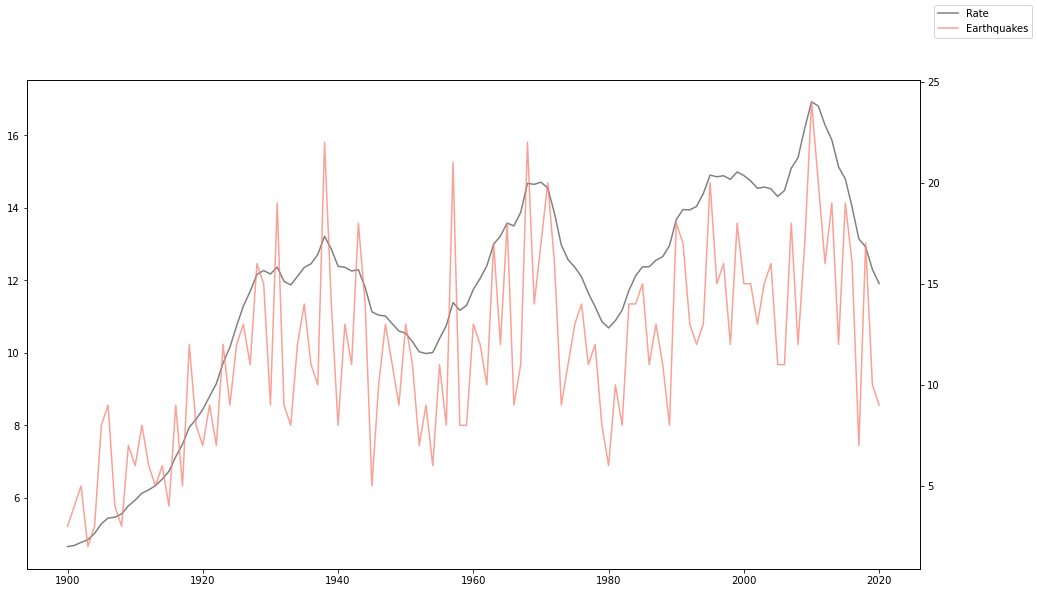

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

smoothed = filt.smooth(state.filter_state.states).mean((1, 2)).exp().cpu().numpy()[1:]
ax.plot(by_year.index, smoothed, color="gray", label="Rate")

ax2 = ax.twinx()
by_year.plot(ax=ax2, color="salmon", alpha=0.75, label="Earthquakes")

fig.legend()

And finally plot the posterior distributions of the parameters.

array([[<AxesSubplot:title={'center':'x\n0'}>,
        <AxesSubplot:title={'center':'x\n0'}>],
       [<AxesSubplot:title={'center':'x\n1'}>,
        <AxesSubplot:title={'center':'x\n1'}>],
       [<AxesSubplot:title={'center':'x\n2'}>,
        <AxesSubplot:title={'center':'x\n2'}>]], dtype=object)

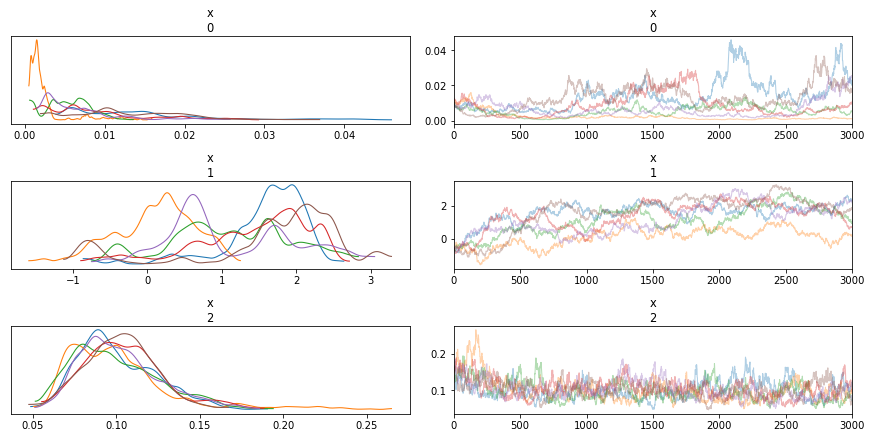

In [18]:
from pyfilter.inference.utils import params_to_tensor
from arviz import plot_trace

parameters = state.samples.values().transpose(1, 0).cpu().numpy()

# fig, ax = plt.subplots(parameters.shape[-1], figsize=(16, 9))

plot_trace(parameters)